# Synthea Data Exploration

This notebook demonstrates the complete data pipeline for EHR sequence modeling:

1. **Loading Synthea data** using `SyntheaAdapter`
2. **Visit grouping** to construct clinical visits from events
3. **Sequence building** to create patient-level sequences
4. **Data statistics** and quality assessment
5. **Visualization** of temporal patterns

---

## Setup

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from datetime import datetime, timedelta

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Import ehrsequencing package
from ehrsequencing.data.adapters import SyntheaAdapter
from ehrsequencing.data.visit_grouper import VisitGrouper
from ehrsequencing.data.sequence_builder import PatientSequenceBuilder

print("✅ Imports successful")

✅ Imports successful


---

## 1. Load Synthea Data

We'll use the `SyntheaAdapter` to load raw EHR data. If you don't have Synthea data, you can:

- Download from: https://synthea.mitre.org/downloads
- Generate synthetic data: https://github.com/synthetichealth/synthea
- Use test fixtures: `../../tests/fixtures/mock_synthea_data/`

In [2]:
# Path to Synthea data
# Option 1: Use your own Synthea data
# data_path = Path('../../data/synthea')
data_path = Path.home() / 'work' / 'loinc-predictor' / 'data' / 'synthea' / 'all_cohorts'
print(data_path)

# Option 2: Use test fixtures (small sample)
# data_path = Path('../../tests/fixtures/mock_synthea_data')

# Initialize adapter
adapter = SyntheaAdapter(data_path=str(data_path))

print(f"✅ Loaded Synthea data from: {data_path}")
print(f"   Data directory exists: {data_path.exists()}")

/Users/pleiadian53/work/loinc-predictor/data/synthea/all_cohorts
✅ Loaded Synthea data from: /Users/pleiadian53/work/loinc-predictor/data/synthea/all_cohorts
   Data directory exists: True


### 1.1 Explore Available Data Files

In [3]:
# List available CSV files
csv_files = list(data_path.glob('*.csv'))

print(f"Found {len(csv_files)} CSV files:")
total_size = 0
for f in sorted(csv_files):
    size_mb = f.stat().st_size / 1024 / 1024
    print(f"  - {f.name:30s} ({size_mb:.2f} MB)")
    total_size += size_mb
print(f"Total size: {total_size:.2f} MB")

Found 18 CSV files:
  - allergies.csv                  (0.01 MB)
  - careplans.csv                  (0.07 MB)
  - claims.csv                     (3.07 MB)
  - claims_transactions.csv        (33.52 MB)
  - conditions.csv                 (0.45 MB)
  - devices.csv                    (0.11 MB)
  - encounters.csv                 (1.60 MB)
  - imaging_studies.csv            (6.22 MB)
  - immunizations.csv              (0.21 MB)
  - medications.csv                (0.84 MB)
  - observations.csv               (9.30 MB)
  - organizations.csv              (0.04 MB)
  - patients.csv                   (0.03 MB)
  - payer_transitions.csv          (0.58 MB)
  - payers.csv                     (0.00 MB)
  - procedures.csv                 (2.86 MB)
  - providers.csv                  (0.04 MB)
  - supplies.csv                   (0.29 MB)
Total size: 59.24 MB


In [4]:
# Load patients
patients = adapter.load_patients(limit=100)  # Load first 100 for exploration

print(f"Total patients loaded: {len(patients)}")
print(f"\nPatient object attributes:")
if patients:
    sample_patient = patients[0]
    print(f"  - patient_id: {sample_patient.patient_id}")
    print(f"  - birth_date: {sample_patient.birth_date}")
    print(f"  - gender: {sample_patient.gender}")
    print(f"  - race: {sample_patient.race}")
    print(f"  - death_date: {sample_patient.death_date}")
    print(f"  - metadata: {sample_patient.metadata}")

    print(f"  - data type: {type(sample_patient)}")

# Convert to DataFrame for analysis
import pandas as pd
patients_df = pd.DataFrame([
    {
        'patient_id': p.patient_id,
        'birth_date': p.birth_date,
        'gender': p.gender,
        'race': p.race,
        'death_date': p.death_date,
        'city': p.metadata.get('city'),
        'state': p.metadata.get('state'),
        'ethnicity': p.metadata.get('ethnicity')
    }
    for p in patients
])

print(f"\nDataFrame shape: {patients_df.shape}")
patients_df.head()

Total patients loaded: 100

Patient object attributes:
  - patient_id: 9b2bcf62-ebf2-0ee3-d063-682358e3c0d0
  - birth_date: 2024-05-05 00:00:00
  - gender: F
  - race: white
  - death_date: None
  - metadata: {'ethnicity': 'nonhispanic', 'city': 'Wilmington', 'state': 'Massachusetts'}
  - data type: <class 'ehrsequencing.data.adapters.base.PatientInfo'>

DataFrame shape: (100, 8)


,patient_id,birth_date,gender,race,death_date,city,state,ethnicity
0,9b2bcf62-ebf2-0ee3-d063-682358e3c0d0,2024-05-05,F,white,NaT,Wilmington,Massachusetts,nonhispanic
1,8f30f356-f7c7-4947-9b72-d61d60a56ac1,2021-04-08,M,white,NaT,Billerica,Massachusetts,nonhispanic
2,dd6e30e4-69d6-42d1-9536-d1f43c506b15,2016-10-26,F,white,NaT,Pittsfield,Massachusetts,hispanic
3,916785c0-9e53-09e5-f13c-69b0196f06fe,1995-09-14,M,black,NaT,Boston,Massachusetts,nonhispanic
4,313d3648-02b3-7c0d-a381-47160df32a9d,2001-07-31,M,white,NaT,Leicester,Massachusetts,nonhispanic


In [5]:
# Patient demographics summary
print("Patient Demographics Summary:")
print("=" * 50)

print(f"\nGender distribution:")
print(patients_df['gender'].value_counts())

print(f"\nRace distribution:")
print(patients_df['race'].value_counts())

print(f"\nState distribution:")
print(patients_df['state'].value_counts())

# Calculate age
patients_df['birth_date'] = pd.to_datetime(patients_df['birth_date'])
patients_df['age'] = (pd.Timestamp.now() - patients_df['birth_date']).dt.days / 365.25

print(f"\nAge statistics:")
print(patients_df['age'].describe())

Patient Demographics Summary:

Gender distribution:
gender
F    58
M    42
Name: count, dtype: int64

Race distribution:
race
white       85
black        8
asian        4
hawaiian     1
other        1
native       1
Name: count, dtype: int64

State distribution:
state
Massachusetts    100
Name: count, dtype: int64

Age statistics:
count    100.000000
mean      36.336318
std       20.761935
min        1.308693
25%       18.500342
50%       36.986995
75%       51.917180
max       86.086242
Name: age, dtype: float64


In [6]:
# Load encounters using raw pandas (adapter returns structured objects)
# For exploration, we'll load CSV directly
encounters_df = pd.read_csv(data_path / 'encounters.csv')

print(f"Total encounters: {len(encounters_df)}")
print(f"Unique patients with encounters: {encounters_df['PATIENT'].nunique()}")
print(f"\nEncounter types:")
if 'ENCOUNTERCLASS' in encounters_df.columns:
    print(encounters_df['ENCOUNTERCLASS'].value_counts())

print(f"\nColumns: {list(encounters_df.columns)}")
encounters_df.head()

Total encounters: 5015
Unique patients with encounters: 106

Encounter types:
ENCOUNTERCLASS
ambulatory    2496
wellness      1201
outpatient     844
emergency      217
urgentcare     134
inpatient       81
virtual         17
snf             14
hospice         11
Name: count, dtype: int64

Columns: ['Id', 'START', 'STOP', 'PATIENT', 'ORGANIZATION', 'PROVIDER', 'PAYER', 'ENCOUNTERCLASS', 'CODE', 'DESCRIPTION', 'BASE_ENCOUNTER_COST', 'TOTAL_CLAIM_COST', 'PAYER_COVERAGE', 'REASONCODE', 'REASONDESCRIPTION']


,Id,START,STOP,PATIENT,ORGANIZATION,PROVIDER,PAYER,ENCOUNTERCLASS,CODE,DESCRIPTION,BASE_ENCOUNTER_COST,TOTAL_CLAIM_COST,PAYER_COVERAGE,REASONCODE,REASONDESCRIPTION
0,9b2bcf62-ebf2-0ee3-8c94-6250d4153fd2,2024-05-05T18:38:29Z,2024-05-05T18:53:29Z,9b2bcf62-ebf2-0ee3-d063-682358e3c0d0,411f14a5-de79-3e08-81d6-301270cc2275,e00d3da0-cd4b-35a4-ae2f-ab2bf4a6e989,d31fccc3-1767-390d-966a-22a5156f4219,wellness,410620009,Well child visit (procedure),136.8,347.38,0.00,NaN,NaN
1,9b2bcf62-ebf2-0ee3-aed8-65055b81f25e,2024-06-09T18:38:29Z,2024-06-09T18:53:29Z,9b2bcf62-ebf2-0ee3-d063-682358e3c0d0,411f14a5-de79-3e08-81d6-301270cc2275,e00d3da0-cd4b-35a4-ae2f-ab2bf4a6e989,d31fccc3-1767-390d-966a-22a5156f4219,wellness,410620009,Well child visit (procedure),136.8,272.80,0.00,NaN,NaN
2,9b2bcf62-ebf2-0ee3-6a12-5d8a52c9c6f4,2024-08-11T18:38:29Z,2024-08-11T18:53:29Z,9b2bcf62-ebf2-0ee3-d063-682358e3c0d0,411f14a5-de79-3e08-81d6-301270cc2275,e00d3da0-cd4b-35a4-ae2f-ab2bf4a6e989,d31fccc3-1767-390d-966a-22a5156f4219,wellness,410620009,Well child visit (procedure),136.8,1679.60,673.42,NaN,NaN
3,9b2bcf62-ebf2-0ee3-1468-067524470bf1,2024-10-13T18:38:29Z,2024-10-13T18:53:29Z,9b2bcf62-ebf2-0ee3-d063-682358e3c0d0,411f14a5-de79-3e08-81d6-301270cc2275,e00d3da0-cd4b-35a4-ae2f-ab2bf4a6e989,d31fccc3-1767-390d-966a-22a5156f4219,wellness,410620009,Well child visit (procedure),136.8,1437.12,1149.70,NaN,NaN
4,9b2bcf62-ebf2-0ee3-f8e6-36425d47a319,2025-01-12T18:38:29Z,2025-01-12T18:53:29Z,9b2bcf62-ebf2-0ee3-d063-682358e3c0d0,411f14a5-de79-3e08-81d6-301270cc2275,e00d3da0-cd4b-35a4-ae2f-ab2bf4a6e989,d31fccc3-1767-390d-966a-22a5156f4219,wellness,410620009,Well child visit (procedure),136.8,816.80,653.44,NaN,NaN


In [7]:
# Load conditions
conditions_df = pd.read_csv(data_path / 'conditions.csv')

print(f"Total condition records: {len(conditions_df)}")
print(f"Unique condition codes: {conditions_df['CODE'].nunique() if len(conditions_df) > 0 else 0}")
print(f"\nMost common conditions:")
if len(conditions_df) > 0:
    top_conditions = conditions_df['DESCRIPTION'].value_counts().head(10)
    for condition, count in top_conditions.items():
        print(f"  {condition:50s} {count:5d}")

conditions_df.head()

Total condition records: 3240
Unique condition codes: 184

Most common conditions:
  Medication review due (situation)                    613
  Stress (finding)                                     239
  Gingivitis (disorder)                                237
  Full-time employment (finding)                       217
  Part-time employment (finding)                       138
  Viral sinusitis (disorder)                           102
  Social isolation (finding)                            84
  Limited social contact (finding)                      76
  Not in labor force (finding)                          74
  Acute viral pharyngitis (disorder)                    68


,START,STOP,PATIENT,ENCOUNTER,SYSTEM,CODE,DESCRIPTION
0,2024-05-05,2024-08-11,9b2bcf62-ebf2-0ee3-d063-682358e3c0d0,9b2bcf62-ebf2-0ee3-8c94-6250d4153fd2,SNOMED-CT,314529007,Medication review due (situation)
1,2024-10-13,2024-10-13,9b2bcf62-ebf2-0ee3-d063-682358e3c0d0,9b2bcf62-ebf2-0ee3-1468-067524470bf1,SNOMED-CT,314529007,Medication review due (situation)
2,2025-01-12,2025-04-13,9b2bcf62-ebf2-0ee3-d063-682358e3c0d0,9b2bcf62-ebf2-0ee3-f8e6-36425d47a319,SNOMED-CT,314529007,Medication review due (situation)
3,2025-07-13,2025-10-12,9b2bcf62-ebf2-0ee3-d063-682358e3c0d0,9b2bcf62-ebf2-0ee3-7e48-ab988a95443c,SNOMED-CT,314529007,Medication review due (situation)
4,2021-04-08,2021-04-08,8f30f356-f7c7-4947-9b72-d61d60a56ac1,8f30f356-f7c7-4947-9b40-be053883bd6c,SNOMED-CT,314529007,Medication review due (situation)


In [8]:
# Load observations (labs)
observations_df = pd.read_csv(data_path / 'observations.csv')

print(f"Total observation records: {len(observations_df)}")
print(f"Unique observation codes: {observations_df['CODE'].nunique() if len(observations_df) > 0 else 0}")
print(f"\nMost common observations:")
if len(observations_df) > 0:
    top_obs = observations_df['DESCRIPTION'].value_counts().head(10)
    for obs, count in top_obs.items():
        print(f"  {obs:50s} {count:5d}")

observations_df.head()

Total observation records: 56225
Unique observation codes: 223

Most common observations:
  Pain severity - 0-10 verbal numeric rating [Score] - Reported  1783
  Systolic Blood Pressure                             1273
  Diastolic Blood Pressure                            1273
  Body Weight                                         1254
  Respiratory rate                                    1216
  Heart rate                                          1216
  Tobacco smoking status                              1187
  Body Height                                         1187
  Body mass index (BMI) [Ratio]                       1057
  QOLS                                                 957


,DATE,PATIENT,ENCOUNTER,CATEGORY,CODE,DESCRIPTION,VALUE,UNITS,TYPE
0,2024-05-05T18:38:29Z,9b2bcf62-ebf2-0ee3-d063-682358e3c0d0,9b2bcf62-ebf2-0ee3-8c94-6250d4153fd2,vital-signs,8302-2,Body Height,54.5,cm,numeric
1,2024-05-05T18:38:29Z,9b2bcf62-ebf2-0ee3-d063-682358e3c0d0,9b2bcf62-ebf2-0ee3-8c94-6250d4153fd2,vital-signs,72514-3,Pain severity - 0-10 verbal numeric rating [Sc...,4.0,{score},numeric
2,2024-05-05T18:38:29Z,9b2bcf62-ebf2-0ee3-d063-682358e3c0d0,9b2bcf62-ebf2-0ee3-8c94-6250d4153fd2,vital-signs,29463-7,Body Weight,4.2,kg,numeric
3,2024-05-05T18:38:29Z,9b2bcf62-ebf2-0ee3-d063-682358e3c0d0,9b2bcf62-ebf2-0ee3-8c94-6250d4153fd2,vital-signs,77606-2,Weight-for-length Per age and sex,10.3,%,numeric
4,2024-05-05T18:38:29Z,9b2bcf62-ebf2-0ee3-d063-682358e3c0d0,9b2bcf62-ebf2-0ee3-8c94-6250d4153fd2,vital-signs,8289-1,Head Occipital-frontal circumference Percentile,89.2,%,numeric


In [9]:
# Load medications
medications_df = pd.read_csv(data_path / 'medications.csv')

print(f"Total medication records: {len(medications_df)}")
print(f"Unique medication codes: {medications_df['CODE'].nunique() if len(medications_df) > 0 else 0}")
print(f"\nMost common medications:")
if len(medications_df) > 0:
    top_meds = medications_df['DESCRIPTION'].value_counts().head(10)
    for med, count in top_meds.items():
        print(f"  {med:50s} {count:5d}")

medications_df.head()

Total medication records: 3384
Unique medication codes: 132

Most common medications:
  1 ML Epoetin Alfa 4000 UNT/ML Injection [Epogen]     348
  Hydrochlorothiazide 25 MG Oral Tablet                329
  lisinopril 10 MG Oral Tablet                         287
  amLODIPine 2.5 MG Oral Tablet                        277
  insulin isophane  human 70 UNT/ML / insulin  regular  human 30 UNT/ML Injectable Suspension [Humulin]   236
  sodium fluoride 0.0272 MG/MG Oral Gel                228
  Cisplatin 50 MG Injection                            197
  PACLitaxel 100 MG Injection                          197
  Acetaminophen 300 MG / Hydrocodone Bitartrate 5 MG Oral Tablet    78
  10 ML Furosemide 10 MG/ML Injection                   68


,START,STOP,PATIENT,PAYER,ENCOUNTER,CODE,DESCRIPTION,BASE_COST,PAYER_COVERAGE,DISPENSES,TOTALCOST,REASONCODE,REASONDESCRIPTION
0,2022-03-04T07:19:52Z,2022-03-18T07:19:52Z,8f30f356-f7c7-4947-9b72-d61d60a56ac1,0133f751-9229-3cfd-815f-b6d4979bdd6a,8f30f356-f7c7-4947-0f8f-99d5db7e02a6,308192,Amoxicillin 500 MG Oral Tablet,44.67,0.0,1,44.67,NaN,NaN
1,2022-03-04T07:19:52Z,2022-03-18T07:19:52Z,8f30f356-f7c7-4947-9b72-d61d60a56ac1,0133f751-9229-3cfd-815f-b6d4979bdd6a,8f30f356-f7c7-4947-0f8f-99d5db7e02a6,313820,Acetaminophen 160 MG Chewable Tablet,45.86,0.0,1,45.86,NaN,NaN
2,2022-05-02T07:43:04Z,2022-05-29T07:43:04Z,8f30f356-f7c7-4947-9b72-d61d60a56ac1,0133f751-9229-3cfd-815f-b6d4979bdd6a,8f30f356-f7c7-4947-f77b-de0972cf3c07,198405,Ibuprofen 100 MG Oral Tablet,51.35,0.0,1,51.35,NaN,NaN
3,2024-03-21T12:50:17Z,2024-03-21T12:50:17Z,8f30f356-f7c7-4947-9b72-d61d60a56ac1,0133f751-9229-3cfd-815f-b6d4979bdd6a,8f30f356-f7c7-4947-d7e0-36ca42b6527b,1535362,sodium fluoride 0.0272 MG/MG Oral Gel,129.94,0.0,1,129.94,103697008.0,Patient referral for dental care (procedure)
4,2024-07-19T07:43:04Z,2024-08-24T07:43:04Z,8f30f356-f7c7-4947-9b72-d61d60a56ac1,0133f751-9229-3cfd-815f-b6d4979bdd6a,8f30f356-f7c7-4947-8c30-4888a42c681d,313820,Acetaminophen 160 MG Chewable Tablet,45.86,0.0,1,45.86,NaN,NaN


In [10]:
# Load procedures
procedures_df = pd.read_csv(data_path / 'procedures.csv')

print(f"Total procedure records: {len(procedures_df)}")
print(f"Unique procedure codes: {procedures_df['CODE'].nunique() if len(procedures_df) > 0 else 0}")
print(f"\nMost common procedures:")
if len(procedures_df) > 0:
    top_procs = procedures_df['DESCRIPTION'].value_counts().head(10)
    for proc, count in top_procs.items():
        print(f"  {proc:50s} {count:5d}")

procedures_df.head()

Total procedure records: 14145
Unique procedure codes: 232

Most common procedures:
  Depression screening (procedure)                    1372
  Assessment of health and social care needs (procedure)   798
  Medication reconciliation (procedure)                586
  Assessment of substance use (procedure)              529
  Dental consultation and report (procedure)           504
  Patient referral for dental care (procedure)         496
  Oral health education (procedure)                    490
  Dental care (regime/therapy)                         485
  Removal of subgingival plaque and calculus from all teeth using dental instrument (procedure)   485
  Examination of gingivae (procedure)                  485


,START,STOP,PATIENT,ENCOUNTER,SYSTEM,CODE,DESCRIPTION,BASE_COST,REASONCODE,REASONDESCRIPTION
0,2024-08-11T18:38:29Z,2024-08-11T18:53:29Z,9b2bcf62-ebf2-0ee3-d063-682358e3c0d0,9b2bcf62-ebf2-0ee3-6a12-5d8a52c9c6f4,SNOMED-CT,430193006,Medication reconciliation (procedure),862.80,NaN,NaN
1,2024-10-13T18:38:29Z,2024-10-13T18:53:29Z,9b2bcf62-ebf2-0ee3-d063-682358e3c0d0,9b2bcf62-ebf2-0ee3-1468-067524470bf1,SNOMED-CT,430193006,Medication reconciliation (procedure),620.32,NaN,NaN
2,2025-04-13T18:38:29Z,2025-04-13T18:53:29Z,9b2bcf62-ebf2-0ee3-d063-682358e3c0d0,9b2bcf62-ebf2-0ee3-e33f-3bf6ca237d80,SNOMED-CT,430193006,Medication reconciliation (procedure),540.97,NaN,NaN
3,2025-10-12T18:38:29Z,2025-10-12T18:53:29Z,9b2bcf62-ebf2-0ee3-d063-682358e3c0d0,9b2bcf62-ebf2-0ee3-8659-c64b2406802e,SNOMED-CT,430193006,Medication reconciliation (procedure),413.95,NaN,NaN
4,2021-04-08T07:19:52Z,2021-04-08T07:34:52Z,8f30f356-f7c7-4947-9b72-d61d60a56ac1,8f30f356-f7c7-4947-9b40-be053883bd6c,SNOMED-CT,430193006,Medication reconciliation (procedure),862.80,NaN,NaN


In [11]:
# Load medications (directly from CSV for exploration)
medications_df = pd.read_csv(data_path / 'medications.csv')

print(f"Total medication records: {len(medications_df)}")
print(f"Unique medication codes: {medications_df['CODE'].nunique() if len(medications_df) > 0 else 0}")
print(f"\nMost common medications:")
if len(medications_df) > 0:
    top_meds = medications_df['DESCRIPTION'].value_counts().head(10)
    for med, count in top_meds.items():
        print(f"  {med:50s} {count:5d}")

medications_df.head()

Total medication records: 3384
Unique medication codes: 132

Most common medications:
  1 ML Epoetin Alfa 4000 UNT/ML Injection [Epogen]     348
  Hydrochlorothiazide 25 MG Oral Tablet                329
  lisinopril 10 MG Oral Tablet                         287
  amLODIPine 2.5 MG Oral Tablet                        277
  insulin isophane  human 70 UNT/ML / insulin  regular  human 30 UNT/ML Injectable Suspension [Humulin]   236
  sodium fluoride 0.0272 MG/MG Oral Gel                228
  Cisplatin 50 MG Injection                            197
  PACLitaxel 100 MG Injection                          197
  Acetaminophen 300 MG / Hydrocodone Bitartrate 5 MG Oral Tablet    78
  10 ML Furosemide 10 MG/ML Injection                   68


,START,STOP,PATIENT,PAYER,ENCOUNTER,CODE,DESCRIPTION,BASE_COST,PAYER_COVERAGE,DISPENSES,TOTALCOST,REASONCODE,REASONDESCRIPTION
0,2022-03-04T07:19:52Z,2022-03-18T07:19:52Z,8f30f356-f7c7-4947-9b72-d61d60a56ac1,0133f751-9229-3cfd-815f-b6d4979bdd6a,8f30f356-f7c7-4947-0f8f-99d5db7e02a6,308192,Amoxicillin 500 MG Oral Tablet,44.67,0.0,1,44.67,NaN,NaN
1,2022-03-04T07:19:52Z,2022-03-18T07:19:52Z,8f30f356-f7c7-4947-9b72-d61d60a56ac1,0133f751-9229-3cfd-815f-b6d4979bdd6a,8f30f356-f7c7-4947-0f8f-99d5db7e02a6,313820,Acetaminophen 160 MG Chewable Tablet,45.86,0.0,1,45.86,NaN,NaN
2,2022-05-02T07:43:04Z,2022-05-29T07:43:04Z,8f30f356-f7c7-4947-9b72-d61d60a56ac1,0133f751-9229-3cfd-815f-b6d4979bdd6a,8f30f356-f7c7-4947-f77b-de0972cf3c07,198405,Ibuprofen 100 MG Oral Tablet,51.35,0.0,1,51.35,NaN,NaN
3,2024-03-21T12:50:17Z,2024-03-21T12:50:17Z,8f30f356-f7c7-4947-9b72-d61d60a56ac1,0133f751-9229-3cfd-815f-b6d4979bdd6a,8f30f356-f7c7-4947-d7e0-36ca42b6527b,1535362,sodium fluoride 0.0272 MG/MG Oral Gel,129.94,0.0,1,129.94,103697008.0,Patient referral for dental care (procedure)
4,2024-07-19T07:43:04Z,2024-08-24T07:43:04Z,8f30f356-f7c7-4947-9b72-d61d60a56ac1,0133f751-9229-3cfd-815f-b6d4979bdd6a,8f30f356-f7c7-4947-8c30-4888a42c681d,313820,Acetaminophen 160 MG Chewable Tablet,45.86,0.0,1,45.86,NaN,NaN


In [13]:
# Load procedures
# procedures_df = adapter.load_procedures()

# Load procedures (directly from CSV for exploration)
procedures_df= pd.read_csv(data_path / 'procedures.csv')

print(f"Total procedure records: {len(procedures_df)}")
print(f"Unique procedure codes: {procedures_df['CODE'].nunique() if len(procedures_df) > 0 else 0}")

procedures_df.head()

Total procedure records: 14145
Unique procedure codes: 232


,START,STOP,PATIENT,ENCOUNTER,SYSTEM,CODE,DESCRIPTION,BASE_COST,REASONCODE,REASONDESCRIPTION
0,2024-08-11T18:38:29Z,2024-08-11T18:53:29Z,9b2bcf62-ebf2-0ee3-d063-682358e3c0d0,9b2bcf62-ebf2-0ee3-6a12-5d8a52c9c6f4,SNOMED-CT,430193006,Medication reconciliation (procedure),862.80,NaN,NaN
1,2024-10-13T18:38:29Z,2024-10-13T18:53:29Z,9b2bcf62-ebf2-0ee3-d063-682358e3c0d0,9b2bcf62-ebf2-0ee3-1468-067524470bf1,SNOMED-CT,430193006,Medication reconciliation (procedure),620.32,NaN,NaN
2,2025-04-13T18:38:29Z,2025-04-13T18:53:29Z,9b2bcf62-ebf2-0ee3-d063-682358e3c0d0,9b2bcf62-ebf2-0ee3-e33f-3bf6ca237d80,SNOMED-CT,430193006,Medication reconciliation (procedure),540.97,NaN,NaN
3,2025-10-12T18:38:29Z,2025-10-12T18:53:29Z,9b2bcf62-ebf2-0ee3-d063-682358e3c0d0,9b2bcf62-ebf2-0ee3-8659-c64b2406802e,SNOMED-CT,430193006,Medication reconciliation (procedure),413.95,NaN,NaN
4,2021-04-08T07:19:52Z,2021-04-08T07:34:52Z,8f30f356-f7c7-4947-9b72-d61d60a56ac1,8f30f356-f7c7-4947-9b40-be053883bd6c,SNOMED-CT,430193006,Medication reconciliation (procedure),862.80,NaN,NaN


---

## 2. Data Statistics

Let's compute summary statistics across all data types.

In [14]:
# Summary statistics
summary = {
    'Metric': [],
    'Count': []
}

summary['Metric'].extend([
    'Total Patients',
    'Total Encounters',
    'Total Conditions',
    'Total Observations',
    'Total Medications',
    'Total Procedures',
    'Unique Condition Codes',
    'Unique Observation Codes',
    'Unique Medication Codes',
    'Unique Procedure Codes'
])

summary['Count'].extend([
    len(patients_df),
    len(encounters_df),
    len(conditions_df),
    len(observations_df),
    len(medications_df),
    len(procedures_df),
    conditions_df['CODE'].nunique() if len(conditions_df) > 0 else 0,
    observations_df['CODE'].nunique() if len(observations_df) > 0 else 0,
    medications_df['CODE'].nunique() if len(medications_df) > 0 else 0,
    procedures_df['CODE'].nunique() if len(procedures_df) > 0 else 0
])

summary_df = pd.DataFrame(summary)
print("\n" + "="*60)
print("DATA SUMMARY")
print("="*60)
print(summary_df.to_string(index=False))
print("="*60)


DATA SUMMARY
                  Metric  Count
          Total Patients    100
        Total Encounters   5015
        Total Conditions   3240
      Total Observations  56225
       Total Medications   3384
        Total Procedures  14145
  Unique Condition Codes    184
Unique Observation Codes    223
 Unique Medication Codes    132
  Unique Procedure Codes    232


### 2.1 Encounters per Patient

Encounters per patient statistics:
count    106.000000
mean      47.311321
std       55.889408
min        8.000000
25%       23.250000
50%       33.500000
75%       50.000000
max      505.000000
dtype: float64


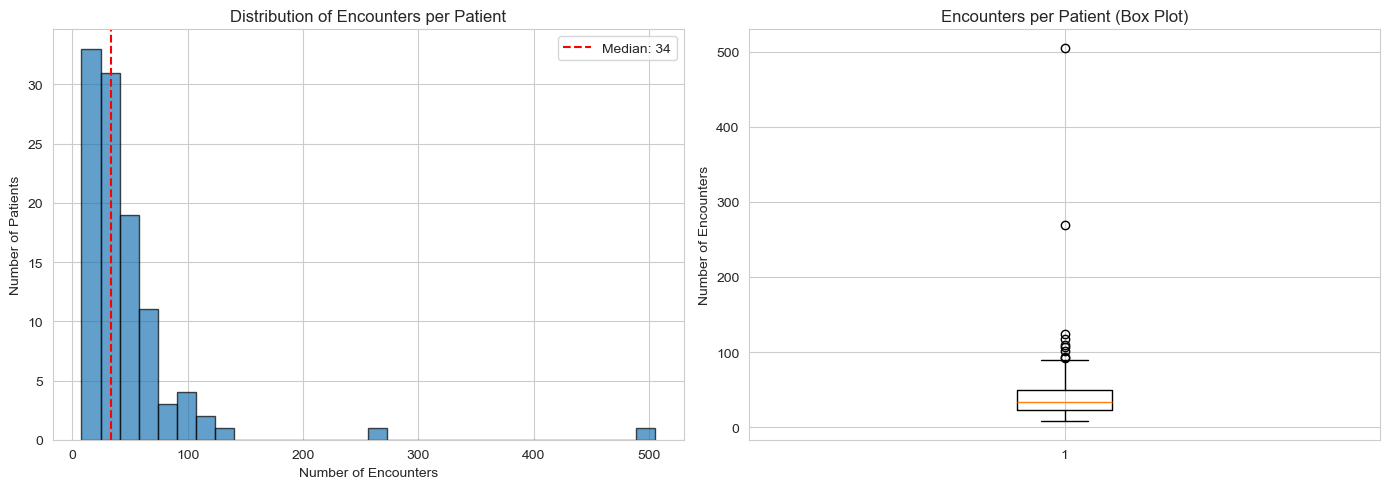

In [15]:
# Encounters per patient
encounters_per_patient = encounters_df.groupby('PATIENT').size()

print("Encounters per patient statistics:")
print(encounters_per_patient.describe())

# Plot distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(encounters_per_patient, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of Encounters')
axes[0].set_ylabel('Number of Patients')
axes[0].set_title('Distribution of Encounters per Patient')
axes[0].axvline(encounters_per_patient.median(), color='red', linestyle='--', label=f'Median: {encounters_per_patient.median():.0f}')
axes[0].legend()

# Box plot
axes[1].boxplot(encounters_per_patient, vert=True)
axes[1].set_ylabel('Number of Encounters')
axes[1].set_title('Encounters per Patient (Box Plot)')

plt.tight_layout()
plt.show()

### 2.2 Code Frequency Analysis

Code type distribution:
  CONDITION      :   3240 (4.2%)
  OBSERVATION    :  56225 (73.0%)
  MEDICATION     :   3384 (4.4%)
  PROCEDURE      :  14145 (18.4%)


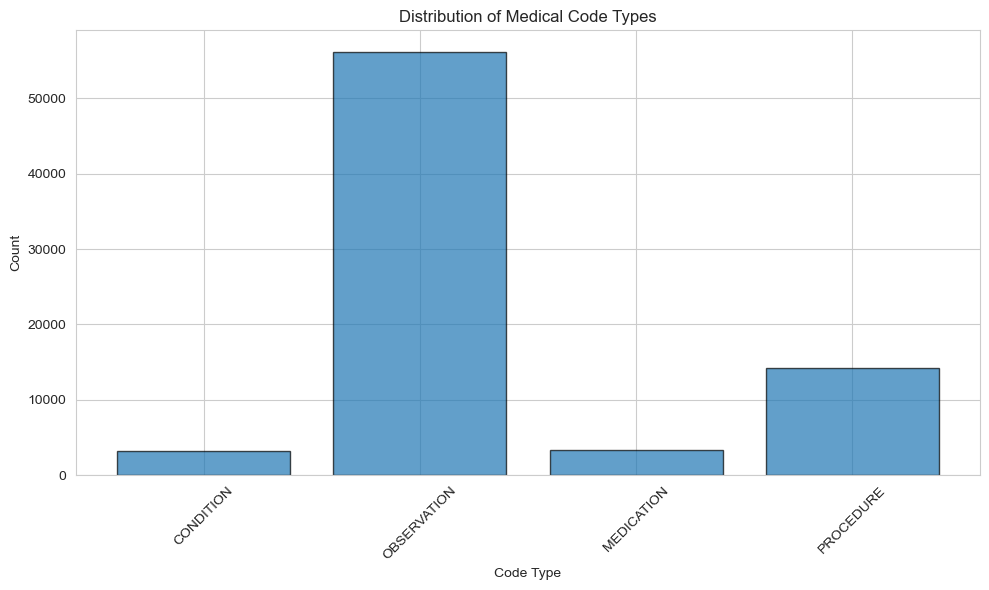

In [16]:
# Combine all medical codes
all_codes = []

if len(conditions_df) > 0:
    all_codes.extend([('CONDITION', code) for code in conditions_df['CODE']])
if len(observations_df) > 0:
    all_codes.extend([('OBSERVATION', code) for code in observations_df['CODE']])
if len(medications_df) > 0:
    all_codes.extend([('MEDICATION', code) for code in medications_df['CODE']])
if len(procedures_df) > 0:
    all_codes.extend([('PROCEDURE', code) for code in procedures_df['CODE']])

# Code type distribution
code_types = [code_type for code_type, _ in all_codes]
code_type_counts = Counter(code_types)

print("Code type distribution:")
for code_type, count in code_type_counts.items():
    print(f"  {code_type:15s}: {count:6d} ({count/len(all_codes)*100:.1f}%)")

# Plot
plt.figure(figsize=(10, 6))
plt.bar(code_type_counts.keys(), code_type_counts.values(), alpha=0.7, edgecolor='black')
plt.xlabel('Code Type')
plt.ylabel('Count')
plt.title('Distribution of Medical Code Types')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---

## 3. Visit Grouping

Now we'll group individual events into clinical visits using the `VisitGrouper`.

In [17]:
# Initialize visit grouper
visit_grouper = VisitGrouper(
    strategy='hybrid',  # Use encounter IDs when available, fallback to same_day
    time_window_hours=24,
    preserve_code_types=True
)

print("✅ VisitGrouper initialized")
print(f"   Strategy: hybrid (encounter IDs + same-day fallback)")
print(f"   Time window: 24 hours")
print(f"   Preserve code types: True")

✅ VisitGrouper initialized
   Strategy: hybrid (encounter IDs + same-day fallback)
   Time window: 24 hours
   Preserve code types: True


In [18]:
# Load events and group into visits for sample patients
patient_ids = [p.patient_id for p in patients[:10]]  # First 10 patients

print(f"Processing {len(patient_ids)} patients...")

# Group visits for each patient
patient_visits = {}
for patient_id in patient_ids:
    # Load events for this patient
    events = adapter.load_events(patient_ids=[patient_id])
    
    # Group events into visits
    visits = visit_grouper.group_events(events, patient_id=patient_id)
    patient_visits[patient_id] = visits
    
    print(f"  Patient {patient_id[:8]}... : {len(events)} events → {len(visits)} visits")

print(f"\n✅ Grouped visits for {len(patient_visits)} patients")

Processing 10 patients...
  Patient 9b2bcf62... : 113 events → 10 visits
  Patient 8f30f356... : 231 events → 24 visits
  Patient dd6e30e4... : 335 events → 39 visits
  Patient 916785c0... : 302 events → 26 visits
  Patient 313d3648... : 277 events → 58 visits
  Patient fd8f9438... : 1315 events → 59 visits
  Patient e97c9d12... : 185 events → 18 visits
  Patient 075171df... : 616 events → 38 visits
  Patient 7deb0d52... : 579 events → 55 visits
  Patient 76e97910... : 419 events → 94 visits

✅ Grouped visits for 10 patients


### 3.1 Examine a Sample Visit

In [20]:
# Pick a patient with visits
sample_patient_id = None
for pid, visits in patient_visits.items():
    if len(visits) > 0:
        sample_patient_id = pid
        break

if sample_patient_id:
    sample_visits = patient_visits[sample_patient_id]
    print(f"Sample patient: {sample_patient_id}")
    print(f"Total visits: {len(sample_visits)}")
    print(f"dtype(sample_visits): {type(sample_visits)}")
    
    if len(sample_visits) > 0:
        print(f"\nFirst visit details:")
        first_visit = sample_visits[0]
        print(f"  Visit ID: {first_visit.visit_id}")
        print(f"  Timestamp: {first_visit.timestamp}")
        print(f"  Encounter ID: {first_visit.encounter_id}")
        print(f"  Number of codes: {first_visit.num_codes()}")
        print(f"  Codes by type: {list(first_visit.codes_by_type.keys())}")
        
        # Show codes by type
        for code_type, codes in first_visit.codes_by_type.items():
            print(f"    {code_type}: {len(codes)} codes")
            if codes:
                print(f"      First 5: {codes[:5]}")
else:
    print("No patients with visits found in sample")

Sample patient: 9b2bcf62-ebf2-0ee3-d063-682358e3c0d0
Total visits: 10
dtype(sample_visits): <class 'list'>

First visit details:
  Visit ID: 9b2bcf62-ebf2-0ee3-8c94-6250d4153fd2
  Timestamp: 2024-05-05 00:00:00
  Encounter ID: 9b2bcf62-ebf2-0ee3-8c94-6250d4153fd2
  Number of codes: 23
  Codes by type: ['diagnosis', 'lab']
    diagnosis: 1 codes
      First 5: ['314529007']
    lab: 22 codes
      First 5: ['8302-2', '72514-3', '29463-7', '77606-2', '8289-1']


### 3.2 Visit Statistics

In [22]:
# Compute visit statistics
visit_stats = {
    'visits_per_patient': [],
    'codes_per_visit': [],
    'time_between_visits': []  # in days
}

for patient_id, visits in patient_visits.items():
    visit_stats['visits_per_patient'].append(len(visits))
    
    for visit in visits:
        visit_stats['codes_per_visit'].append(visit.num_codes())  # Use num_codes() method
    
    # Time between consecutive visits
    if len(visits) > 1:
        for i in range(1, len(visits)):
            time_diff = (visits[i].timestamp - visits[i-1].timestamp).total_seconds() / 86400
            visit_stats['time_between_visits'].append(time_diff)

# Print statistics
print("Visit Statistics:")
print("=" * 60)

if visit_stats['visits_per_patient']:
    print(f"\nVisits per patient:")
    print(f"  Mean: {np.mean(visit_stats['visits_per_patient']):.2f}")
    print(f"  Median: {np.median(visit_stats['visits_per_patient']):.2f}")
    print(f"  Min: {np.min(visit_stats['visits_per_patient'])}")
    print(f"  Max: {np.max(visit_stats['visits_per_patient'])}")

if visit_stats['codes_per_visit']:
    print(f"\nCodes per visit:")
    print(f"  Mean: {np.mean(visit_stats['codes_per_visit']):.2f}")
    print(f"  Median: {np.median(visit_stats['codes_per_visit']):.2f}")
    print(f"  Min: {np.min(visit_stats['codes_per_visit'])}")
    print(f"  Max: {np.max(visit_stats['codes_per_visit'])}")

if visit_stats['time_between_visits']:
    print(f"\nTime between visits (days):")
    print(f"  Mean: {np.mean(visit_stats['time_between_visits']):.2f}")
    print(f"  Median: {np.median(visit_stats['time_between_visits']):.2f}")
    print(f"  Min: {np.min(visit_stats['time_between_visits']):.2f}")
    print(f"  Max: {np.max(visit_stats['time_between_visits']):.2f}")

Visit Statistics:

Visits per patient:
  Mean: 42.10
  Median: 38.50
  Min: 10
  Max: 94

Codes per visit:
  Mean: 10.38
  Median: 3.00
  Min: 1
  Max: 298

Time between visits (days):
  Mean: 114.30
  Median: 28.00
  Min: 0.00
  Max: 4388.57


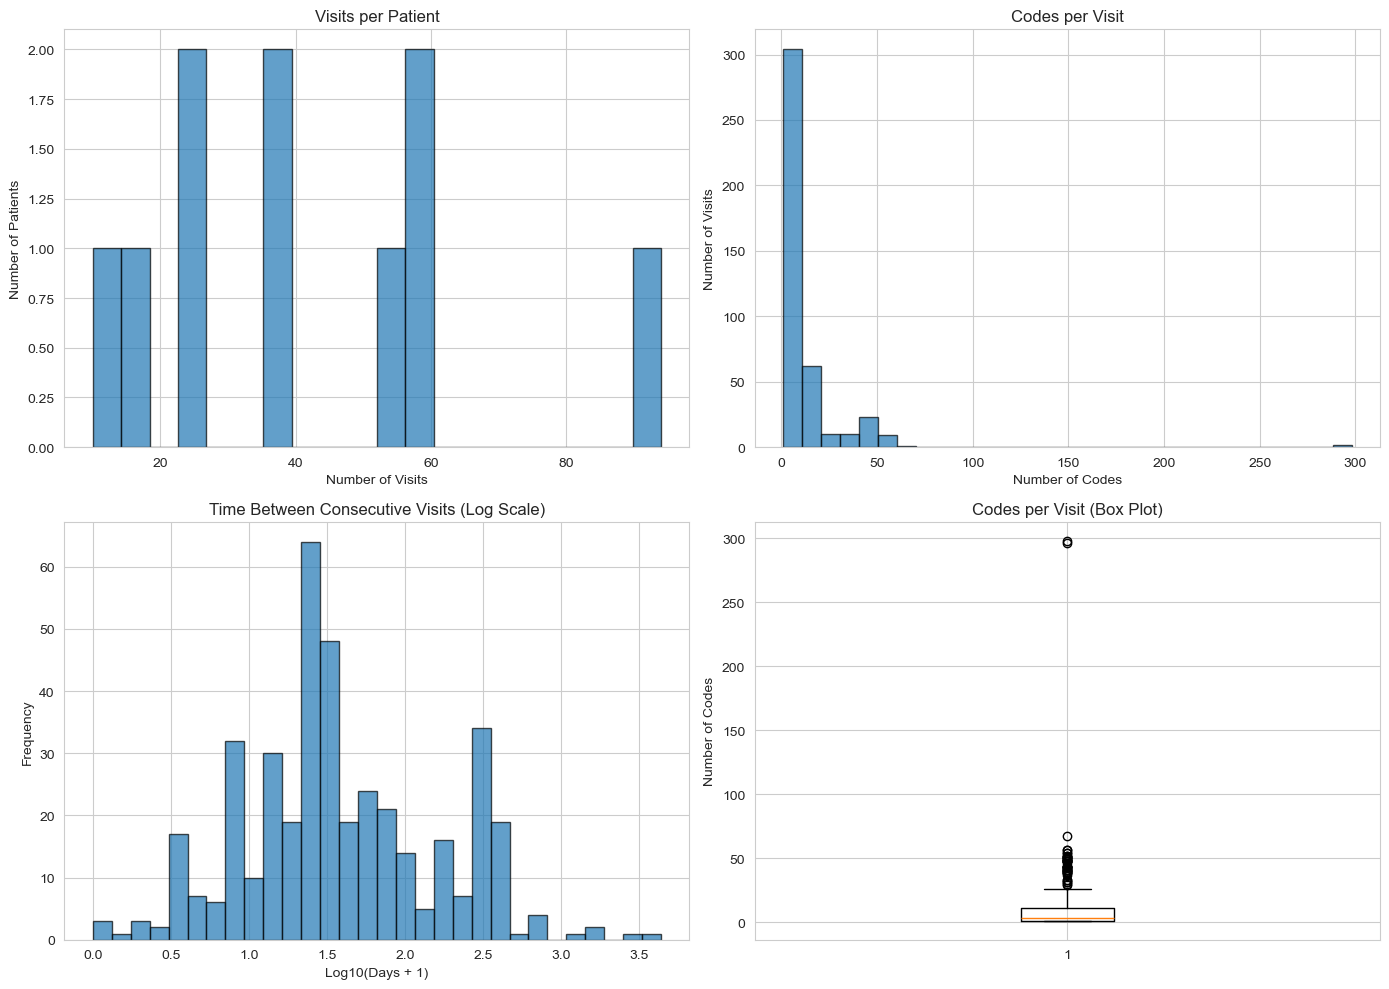

In [23]:
# Visualize visit statistics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Visits per patient
if visit_stats['visits_per_patient']:
    axes[0, 0].hist(visit_stats['visits_per_patient'], bins=20, edgecolor='black', alpha=0.7)
    axes[0, 0].set_xlabel('Number of Visits')
    axes[0, 0].set_ylabel('Number of Patients')
    axes[0, 0].set_title('Visits per Patient')

# Codes per visit
if visit_stats['codes_per_visit']:
    axes[0, 1].hist(visit_stats['codes_per_visit'], bins=30, edgecolor='black', alpha=0.7)
    axes[0, 1].set_xlabel('Number of Codes')
    axes[0, 1].set_ylabel('Number of Visits')
    axes[0, 1].set_title('Codes per Visit')

# Time between visits (log scale)
if visit_stats['time_between_visits']:
    axes[1, 0].hist(np.log10(np.array(visit_stats['time_between_visits']) + 1), bins=30, edgecolor='black', alpha=0.7)
    axes[1, 0].set_xlabel('Log10(Days + 1)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Time Between Consecutive Visits (Log Scale)')

# Codes per visit (box plot)
if visit_stats['codes_per_visit']:
    axes[1, 1].boxplot(visit_stats['codes_per_visit'], vert=True)
    axes[1, 1].set_ylabel('Number of Codes')
    axes[1, 1].set_title('Codes per Visit (Box Plot)')

plt.tight_layout()
plt.show()

---

## 4. Sequence Building

Now we'll build patient sequences suitable for modeling using `PatientSequenceBuilder`.

In [25]:
# Initialize sequence builder
# Note: PatientSequenceBuilder works with already-grouped visits
# We'll build vocabulary first, then create sequences
sequence_builder = PatientSequenceBuilder(
    vocab=None,  # Will build vocabulary from data
    max_visits=50,
    max_codes_per_visit=100,
    use_semantic_order=True
)

print("✅ PatientSequenceBuilder initialized")
print(f"   Max visits: 50")
print(f"   Max codes per visit: 100")
print(f"   Use semantic order: True")

✅ PatientSequenceBuilder initialized
   Max visits: 50
   Max codes per visit: 100
   Use semantic order: True


In [27]:
# Build vocabulary from patient visits
print("Building vocabulary from patient data...")
sequence_builder.build_vocabulary(patient_visits, min_frequency=1)

vocab_size = len(sequence_builder.vocab)
print(f"\n✅ Vocabulary built")
print(f"   Vocabulary size: {vocab_size}")
print(f"   Special tokens: [PAD]=0, [UNK]=1, [MASK]=2, [CLS]=3, [SEP]=4")

Building vocabulary from patient data...

✅ Vocabulary built
   Vocabulary size: 337
   Special tokens: [PAD]=0, [UNK]=1, [MASK]=2, [CLS]=3, [SEP]=4


In [29]:
# Build sequences from patient visits
print("Building patient sequences...")
sequences = sequence_builder.build_sequences(patient_visits, min_visits=2)

print(f"\n✅ Built {len(sequences)} sequences")
print(f"   Total patients: {len(patient_visits)}")
print(f"   Filtered out: {len(patient_visits) - len(sequences)} patients (< min_visits)")

# Show sequence statistics
if sequences:
    seq_lengths = [seq.sequence_length for seq in sequences]
    print(f"\nSequence length statistics:")
    print(f"   Mean: {np.mean(seq_lengths):.2f}")
    print(f"   Median: {np.median(seq_lengths):.2f}")
    print(f"   Min: {np.min(seq_lengths)}")
    print(f"   Max: {np.max(seq_lengths)}")

Building patient sequences...

✅ Built 10 sequences
   Total patients: 10
   Filtered out: 0 patients (< min_visits)

Sequence length statistics:
   Mean: 42.10
   Median: 38.50
   Min: 10
   Max: 94


### 4.1 Examine Sample Sequence

In [31]:
if sequences:
    sample_seq = sequences[0]
    
    print("Sample sequence:")
    print(f"  Patient ID: {sample_seq.patient_id}")
    print(f"  Number of visits: {sample_seq.sequence_length}")
    print(f"  Metadata: {sample_seq.metadata}")
    
    print(f"\nFirst visit:")
    first_visit = sample_seq.visits[0]
    print(f"  Visit ID: {first_visit.visit_id}")
    print(f"  Timestamp: {first_visit.timestamp}")
    print(f"  Number of codes: {first_visit.num_codes()}")
    print(f"  Codes by type: {list(first_visit.codes_by_type.keys())}")
    
    # Show first few codes
    all_codes = first_visit.get_all_codes()
    print(f"  All codes (first 10): {all_codes[:10]}")
else:
    print("No sequences built")

Sample sequence:
  Patient ID: 9b2bcf62-ebf2-0ee3-d063-682358e3c0d0
  Number of visits: 10
  Metadata: {'total_codes': 113, 'avg_codes_per_visit': 11.3}

First visit:
  Visit ID: 9b2bcf62-ebf2-0ee3-8c94-6250d4153fd2
  Timestamp: 2024-05-05 00:00:00
  Number of codes: 23
  Codes by type: ['diagnosis', 'lab']
  All codes (first 10): ['314529007', '8302-2', '72514-3', '29463-7', '77606-2', '8289-1', '9843-4', '8462-4', '8480-6', '8867-4']


### 4.2 Sequence Length Distribution

Sequence length statistics:
  Mean: 42.10
  Median: 38.50
  Min: 10
  Max: 94
  Std: 23.71


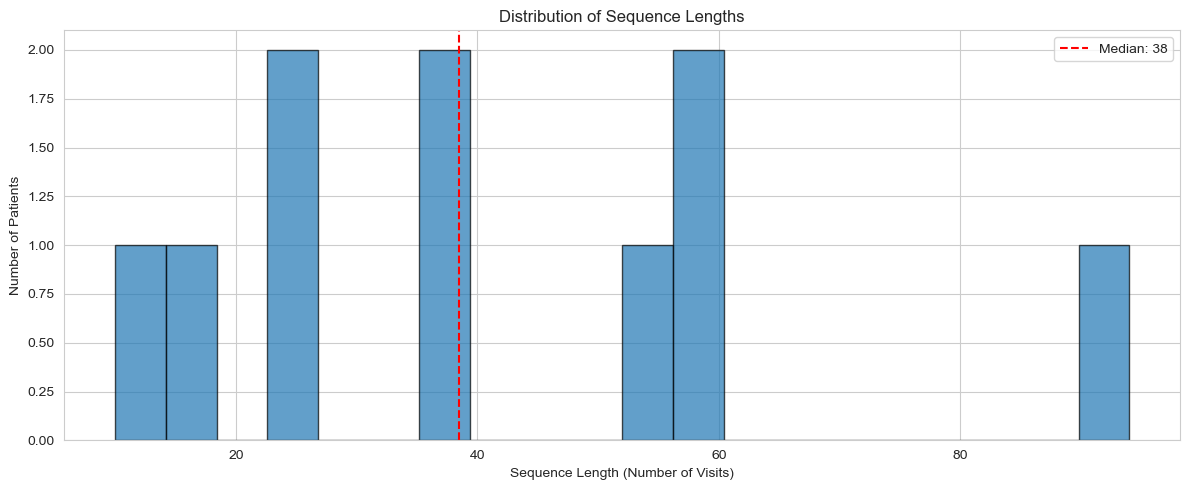

In [33]:
if sequences:
    sequence_lengths = [seq.sequence_length for seq in sequences]
    
    print("Sequence length statistics:")
    print(f"  Mean: {np.mean(sequence_lengths):.2f}")
    print(f"  Median: {np.median(sequence_lengths):.2f}")
    print(f"  Min: {np.min(sequence_lengths)}")
    print(f"  Max: {np.max(sequence_lengths)}")
    print(f"  Std: {np.std(sequence_lengths):.2f}")
    
    # Plot
    plt.figure(figsize=(12, 5))
    plt.hist(sequence_lengths, bins=20, edgecolor='black', alpha=0.7)
    plt.xlabel('Sequence Length (Number of Visits)')
    plt.ylabel('Number of Patients')
    plt.title('Distribution of Sequence Lengths')
    plt.axvline(np.median(sequence_lengths), color='red', linestyle='--', label=f'Median: {np.median(sequence_lengths):.0f}')
    plt.legend()
    plt.tight_layout()
    plt.show()

---

## 5. Data Quality Assessment

In [ ]:
print("Data Quality Assessment:")
print("=" * 60)

# Missing data
print("\n1. Missing Data:")
for df_name, df in [
    ('Patients', patients_df),
    ('Encounters', encounters_df),
    ('Conditions', conditions_df),
    ('Observations', observations_df),
    ('Medications', medications_df),
    ('Procedures', procedures_df)
]:
    if len(df) > 0:
        missing_pct = (df.isnull().sum() / len(df) * 100)
        if missing_pct.sum() > 0:
            print(f"\n  {df_name}:")
            for col, pct in missing_pct[missing_pct > 0].items():
                print(f"    {col}: {pct:.1f}% missing")

# Patients with no encounters
patients_with_encounters = set(encounters_df['PATIENT'].unique())
patients_without_encounters = set(patients_df['patient_id']) - patients_with_encounters
print(f"\n2. Patients without encounters: {len(patients_without_encounters)} ({len(patients_without_encounters)/len(patients_df)*100:.1f}%)")

# Sequence statistics
if sequences:
    total_visits = sum(seq.sequence_length for seq in sequences)
    total_codes = sum(visit.num_codes() for seq in sequences for visit in seq.visits)
    print(f"\n3. Sequence coverage:")
    print(f"   Total sequences: {len(sequences)}")
    print(f"   Total visits: {total_visits}")
    print(f"   Total codes: {total_codes}")
    print(f"   Vocabulary size: {len(sequence_builder.vocab)}")

print("\n" + "=" * 60)

Data Quality Assessment:

1. Missing Data:

  Patients:
    death_date: 94.0% missing

  Encounters:
    REASONCODE: 35.9% missing
    REASONDESCRIPTION: 35.9% missing

  Conditions:
    STOP: 25.6% missing

  Observations:
    ENCOUNTER: 5.1% missing
    CATEGORY: 5.1% missing
    UNITS: 29.6% missing

  Medications:
    STOP: 6.4% missing
    REASONCODE: 21.9% missing
    REASONDESCRIPTION: 21.9% missing

  Procedures:
    REASONCODE: 51.6% missing
    REASONDESCRIPTION: 51.6% missing


KeyError: 'Id'

---

## 6. Temporal Patterns

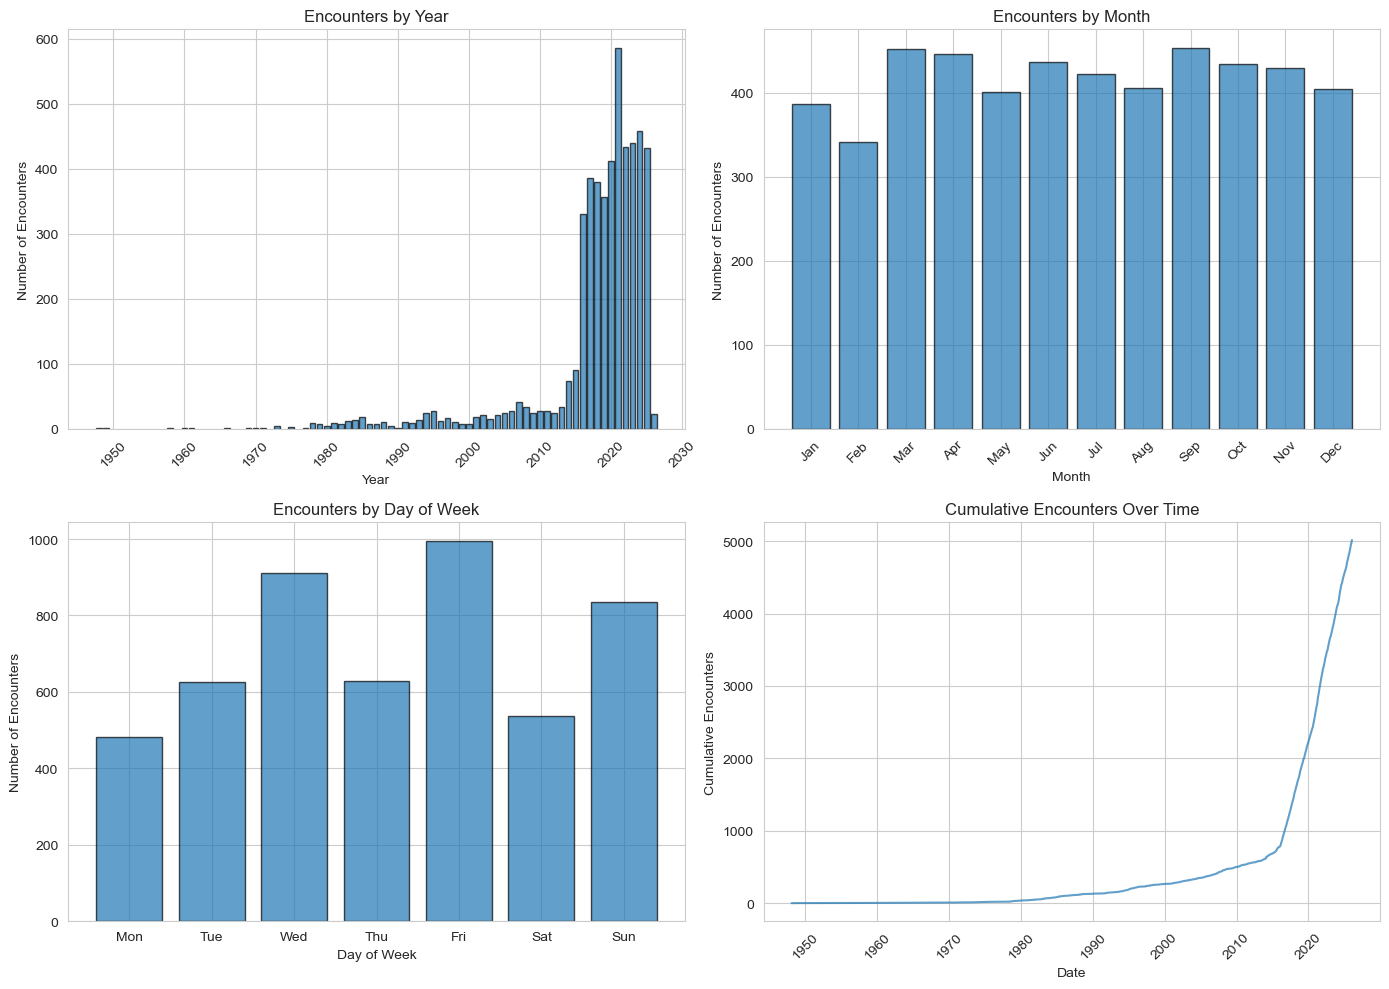

In [35]:
# Extract timestamps from encounters
if 'START' in encounters_df.columns:
    encounters_df['START'] = pd.to_datetime(encounters_df['START'])
    encounters_df['YEAR'] = encounters_df['START'].dt.year
    encounters_df['MONTH'] = encounters_df['START'].dt.month
    encounters_df['DAY_OF_WEEK'] = encounters_df['START'].dt.dayofweek
    
    # Encounters by year
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # By year
    year_counts = encounters_df['YEAR'].value_counts().sort_index()
    axes[0, 0].bar(year_counts.index, year_counts.values, alpha=0.7, edgecolor='black')
    axes[0, 0].set_xlabel('Year')
    axes[0, 0].set_ylabel('Number of Encounters')
    axes[0, 0].set_title('Encounters by Year')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # By month
    month_counts = encounters_df['MONTH'].value_counts().sort_index()
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    axes[0, 1].bar(range(1, 13), [month_counts.get(i, 0) for i in range(1, 13)], alpha=0.7, edgecolor='black')
    axes[0, 1].set_xlabel('Month')
    axes[0, 1].set_ylabel('Number of Encounters')
    axes[0, 1].set_title('Encounters by Month')
    axes[0, 1].set_xticks(range(1, 13))
    axes[0, 1].set_xticklabels(month_names, rotation=45)
    
    # By day of week
    dow_counts = encounters_df['DAY_OF_WEEK'].value_counts().sort_index()
    dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    axes[1, 0].bar(range(7), [dow_counts.get(i, 0) for i in range(7)], alpha=0.7, edgecolor='black')
    axes[1, 0].set_xlabel('Day of Week')
    axes[1, 0].set_ylabel('Number of Encounters')
    axes[1, 0].set_title('Encounters by Day of Week')
    axes[1, 0].set_xticks(range(7))
    axes[1, 0].set_xticklabels(dow_names)
    
    # Timeline (cumulative encounters)
    encounters_sorted = encounters_df.sort_values('START')
    encounters_sorted['CUMULATIVE'] = range(1, len(encounters_sorted) + 1)
    axes[1, 1].plot(encounters_sorted['START'], encounters_sorted['CUMULATIVE'], alpha=0.7)
    axes[1, 1].set_xlabel('Date')
    axes[1, 1].set_ylabel('Cumulative Encounters')
    axes[1, 1].set_title('Cumulative Encounters Over Time')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

---

## 7. Summary and Next Steps

### What We've Explored

1. ✅ Loaded Synthea EHR data using `SyntheaAdapter`
2. ✅ Analyzed patient demographics and clinical events
3. ✅ Grouped events into visits using `VisitGrouper`
4. ✅ Built patient sequences using `PatientSequenceBuilder`
5. ✅ Assessed data quality and temporal patterns

### Key Findings

- **Data volume**: Summary statistics on patients, encounters, and codes
- **Visit patterns**: Distribution of visits per patient and codes per visit
- **Sequence characteristics**: Variable-length sequences suitable for LSTM modeling
- **Temporal patterns**: Seasonal and weekly trends in healthcare utilization

### Next Steps

1. **Train LSTM baseline model**:
   ```bash
   python examples/train_lstm_baseline.py \
       --data-path data/synthea \
       --output-dir results/lstm_baseline
   ```

2. **Implement Med2Vec embeddings** (Phase 2)

3. **Explore advanced models** (Transformers, BEHRT)

4. **Define prediction tasks** (mortality, readmission, disease progression)

---

## References

- **Synthea**: https://synthea.mitre.org/
- **LSTM for EHR**: Choi et al., "Doctor AI" (2016)
- **BEHRT**: Li et al., "BEHRT: Transformer for Electronic Health Records" (2020)
- **Med2Vec**: Choi et al., "Multi-layer Representation Learning for Medical Concepts" (2016)